# Pytorch implementation
---

In [220]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision.datasets as dataset

from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
from PIL import Image

import os
import numpy as np
import pandas as pd

### Resizing images

The original images were ~3000x3000. I have resized it to 300x300 for computational efficiency

In [221]:
sz = (300,300) #specify the final size

In [222]:
# fn1 = !ls data/normal
# fn2 = !ls data/condition

In [223]:
# for n in fn1:
# #     set_trace()
# #     print(n)
#     im = Image.open(f'data/normal/{n}')
#     im.thumbnail(sz,Image.ANTIALIAS)
#     im.save(f'data/montgomery_china_resized/normal/{n}',format='png')
    

In [224]:
# for n in fn2:
# #     set_trace()
# #     print(n)
#     im = Image.open(f'data/condition/{n}')
#     im.thumbnail(sz,Image.ANTIALIAS)
#     im.save(f'data/montgomery_china_resized/condition/{n}',format='png')

---

We have 800 X-ray images. We have split it into train (680 images) and validation (120 images). 

### Sample image

In [225]:
path = 'data/'

In [226]:
sample = plt.imread('data/montgomery_china_resized/train/normal/CHNCXR_0001_0.png')

In [227]:
sample.shape

(291, 300, 3)

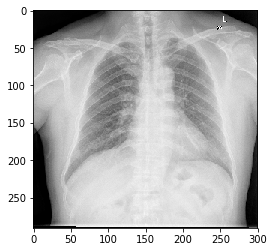

In [228]:
plt.imshow(sample)

---

### Transforms

Below are some few kind of transforms that are generally used for data augmentation

In [229]:
sample = Image.open('data/montgomery_china_resized/train/normal/CHNCXR_0001_0.png')

#### Center Crop

In [230]:
t = transforms.CenterCrop(200)

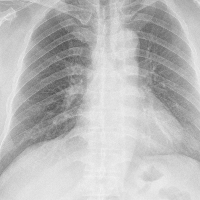

In [231]:
t(sample)

#### Random Crop

In [232]:
t = transforms.RandomCrop(250)

In [233]:
t(sample).size

(250, 250)

#### Horizontal Flip

In [234]:
t = transforms.RandomHorizontalFlip()

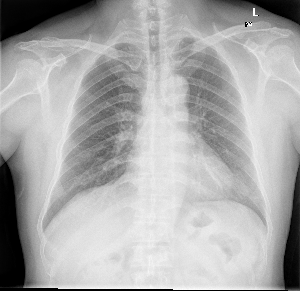

In [235]:
t(sample)

#### Vertical Flip

In [236]:
t = transforms.RandomVerticalFlip()

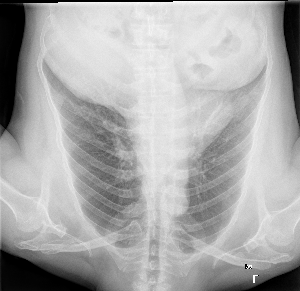

In [237]:
t(sample)

#### Rotation

In [238]:
t = transforms.RandomRotation((0,20))

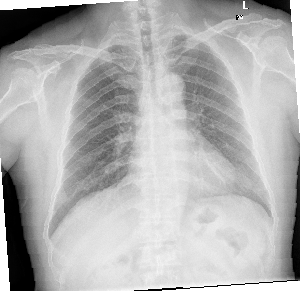

In [239]:
t(sample)

#### Defining transforms for this dataset

In [287]:
# Specifying your transforms
transform = transforms.Compose([
    transforms.RandomCrop(224), #the output size should be less than the original size of the input image if using RandomCrop
    transforms.RandomRotation(1),
#     transforms.RandomResizedCrop(300),
    transforms.ToTensor()
])

---

### Data Loader

In [263]:
batch_size = 8

This method of data loader is used if we have 2 folders train and validation and there are separate folders for each class within them

In [264]:
#for training
traindir = os.path.join('data/montgomery_china_resized/', 'train')
train = dataset.ImageFolder(traindir, transform)
train_loader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)

In [265]:
#for validation
valdir = os.path.join('data/montgomery_china_resized/', 'valid')
valid = dataset.ImageFolder(valdir, transform)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

---

### Building your CNN network

In [272]:
# CNN Model (4 conv layer)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())      
        self.fc = nn.Linear(28*28*128, 2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
#         out = nn.LogSoftmax(out)
        return out

In [278]:
cnn = CNN() #instantiating your CNN class
# cnn.cuda()#shifting it to gpu
criterion = nn.CrossEntropyLoss() #defining your loss
optimizer = torch.optim.Adam(cnn.parameters(), lr=.001) #defining your optimizer and learning rate

---

### Training of the network

In [279]:
num_epochs = 3

In [280]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images)
#         images = Variable(images).cuda() #for gpu
        labels = Variable(labels)
#         labels = Variable(labels).cuda() #for gpu
        
        # Forward + Backward + Optimize
        optimizer.zero_grad() #putting all gradients to zero
        outputs = cnn(images) #forward pass
        loss = criterion(outputs, labels) #calculating loss
        loss.backward() #backward pass to calculate gradients
        optimizer.step() #updating the network parameters
        
        if (i+1) % 10 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train)//batch_size, loss.data[0]))

Epoch [1/3], Iter [10/85] Loss: 19.8310
Epoch [1/3], Iter [20/85] Loss: 3.0897
Epoch [1/3], Iter [30/85] Loss: 5.1605
Epoch [1/3], Iter [40/85] Loss: 15.6129
Epoch [2/3], Iter [10/85] Loss: 5.0555
Epoch [2/3], Iter [20/85] Loss: 7.8952
Epoch [2/3], Iter [30/85] Loss: 5.3767
Epoch [2/3], Iter [40/85] Loss: 1.5142
Epoch [3/3], Iter [10/85] Loss: 0.7204
Epoch [3/3], Iter [20/85] Loss: 7.1600
Epoch [3/3], Iter [30/85] Loss: 0.8160
Epoch [3/3], Iter [40/85] Loss: 4.0195


---

### Predicting on validation set

In [281]:
cnn.eval()    # Change model to 'eval' mode (BN uses moving mean/var).
correct = 0
total = 0
for images, labels in valid_loader:
    images = Variable(images)
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum()

print('Test Accuracy of the model on the 120 validation images: %d %%' % (100 * correct / total))

# Save the Trained Model
torch.save(cnn.state_dict(), 'cnn.pkl')

Test Accuracy of the model on the 10000 test images: 68 %


---

# Keras implementation

In [286]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
# from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow